In [60]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import astropy.io.fits as fits

In [61]:
def alm_udgrade(map_in, nside_out):
    alm_in = get_alms(map_in)
    lmax_out = 3*nside_out - 1
    alm_out = hp.almxfl(alm_in, np.ones(lmax_out + 1))
    map_out = hp.alm2map(alm_out, nside_out)
    return map_out

def get_alms(map_in):
    nside_in = hp.get_nside(map_in)
    lmax_in = 3*nside_in - 1
    alm = hp.map2alm(map_in, lmax = lmax_in)
    return alm

In [62]:
def apply_mask(map, mask):
    masked_index = np.where(mask != 1)
    masked_map = map.copy()
    masked_map[masked_index] = hp.UNSEEN
    masked_map = hp.ma(masked_map)
    #masked_map.mask = mask
    return masked_map

def calc_fsky(mask):
    return np.sum(mask**2)/len(mask)

In [63]:
def beam_deconvol(map_in, beam, nside):
    alm_in = get_alms(map_in)
    alm_out = hp.almxfl(alm_in, 1/beam)
    map_out = hp.alm2map(alm_out, nside)
    return map_out

In [64]:
def cal_raw_dl(map_in1, ellmax, map_in2 = None):
    if map_in2 is not None:
        raw_cl = hp.anafast(map_in1, map_in2, lmax=ellmax)
    else:
        raw_cl = hp.anafast(map_in1, lmax=ellmax)
    ell_temp = np.arange(len(raw_cl))
    raw_dl = ell_temp * (ell_temp + 1) * raw_cl / (2 * np.pi)
    return raw_dl

def cal_masked_dl(map_in1, mask, ellmax, map_in2 = None):
    fsky = calc_fsky(mask)
    if map_in2 is not None:
        masked_map1 = apply_mask(map_in1, mask)
        masked_map2 = apply_mask(map_in2, mask)
        masked_cl = hp.anafast(masked_map1, masked_map2, lmax=ellmax)
    else:
        masked_map = apply_mask(map_in1, mask)
        masked_cl = hp.anafast(masked_map, lmax=ellmax)
    ell_temp = np.arange(len(masked_cl))
    masked_dl = ell_temp * (ell_temp + 1) * masked_cl / (2 * np.pi) / fsky
    return masked_dl

def cal_apod_masked_dl(map_in1, mask_in, ellmax, apod_scale, map_in2 = None):
    apodized_mask = nmt.mask_apodization(mask_in, apod_scale, apotype='C2')
    fsky = calc_fsky(apodized_mask)
    if map_in2 is not None:
        masked_map1 = apply_mask(map_in1, apodized_mask)
        masked_map2 = apply_mask(map_in2, apodized_mask)
        masked_cl = hp.anafast(masked_map1, masked_map2, lmax=ellmax)
    else:
        masked_map = apply_mask(map_in1, apodized_mask)
        masked_cl = hp.anafast(masked_map, lmax=ellmax)
    ell_temp = np.arange(len(masked_cl))
    masked_dl = ell_temp * (ell_temp + 1) * masked_cl / (2 * np.pi) / fsky
    return masked_dl

In [65]:
def absolute_error(dl1, dl2):
    return (dl1 - dl2)

def relative_error(dl1, dl2):
    return 100*(dl1 - dl2) / dl2

In [66]:
nside = 512

Output Pyilc maps are convolved with a beam of FWHM 20.6 arcmin

In [67]:
beam_fwhm = 20.6
beam_fwhm = beam_fwhm*np.pi / 60 / 180 
beam = hp.gauss_beam(beam_fwhm, lmax= 3*nside - 1)

Load the maps at full resolution 2048

In [68]:
nilc_cmb_path = '/home/yunan/COM_CMB_IQU-nilc_2048_R3.00_full.fits'
fits_file = fits.open(nilc_cmb_path)

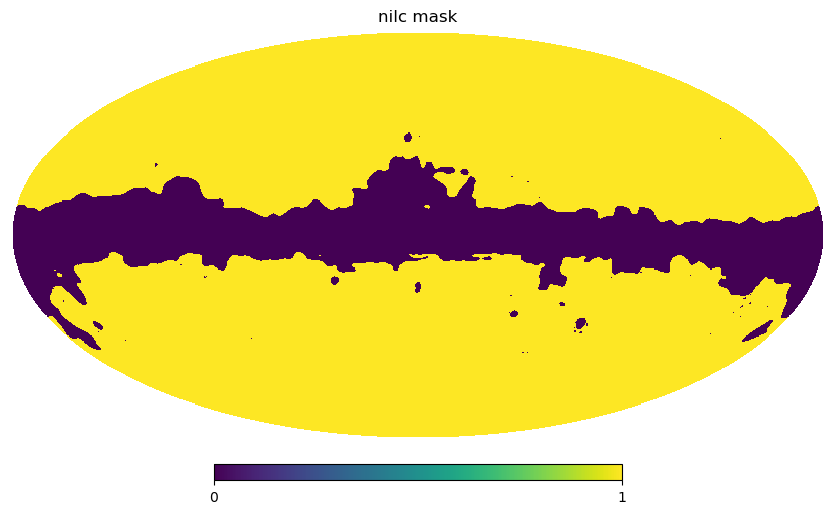

In [69]:
nilc_mask = fits_file[1].data['TMASK']
nilc_mask = hp.reorder(nilc_mask, n2r=True)
hp.mollview(nilc_mask, title='nilc mask', unit='')

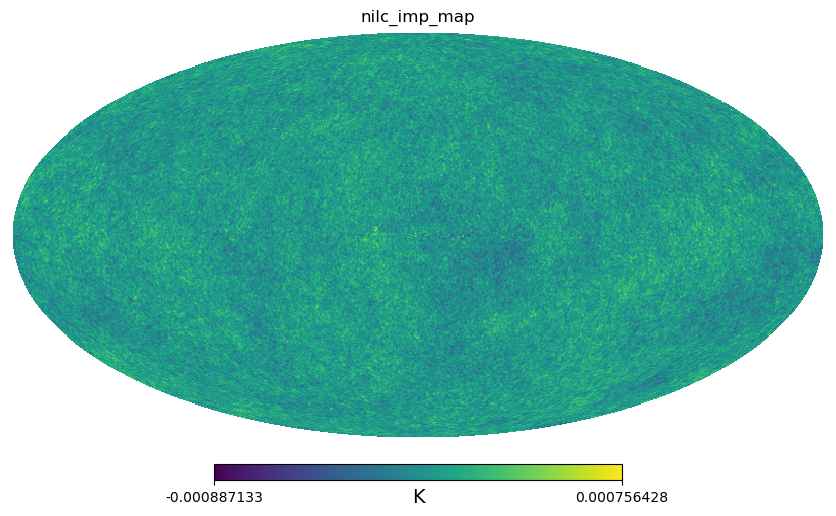

In [70]:
nilc_imp_map = fits_file[1].data['I_STOKES']
nilc_imp_map = hp.reorder(nilc_imp_map, n2r=True)
hp.mollview(nilc_imp_map, title='nilc_imp_map', unit='K')

Load the Planck beam to deconvolve the NILC CMB map

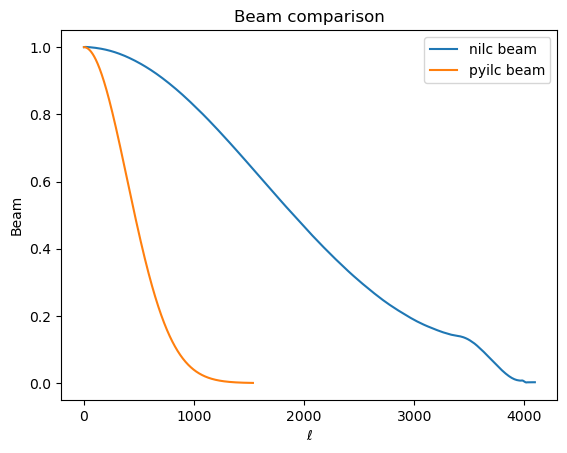

In [71]:
nilc_beam = fits_file[2].data['INT_BEAM']
nilc_beam[0] = 1
nilc_beam[1] = 0.99999962
plt.plot(nilc_beam, label='nilc beam')
plt.plot(beam, label='pyilc beam')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel('Beam')
plt.title('Beam comparison')
plt.show()

Deconvolve the nilc cmb map

In [72]:
filtered_nilc_map = beam_deconvol(nilc_imp_map, nilc_beam, 2048)

Downgrade the NILC cmb map and smooth with Pyilc beam

In [73]:
downgraded_nilc_map = alm_udgrade(filtered_nilc_map, nside)
low_res_nilc_map = beam_deconvol(downgraded_nilc_map, 1/beam, nside)

Downgrade the mask

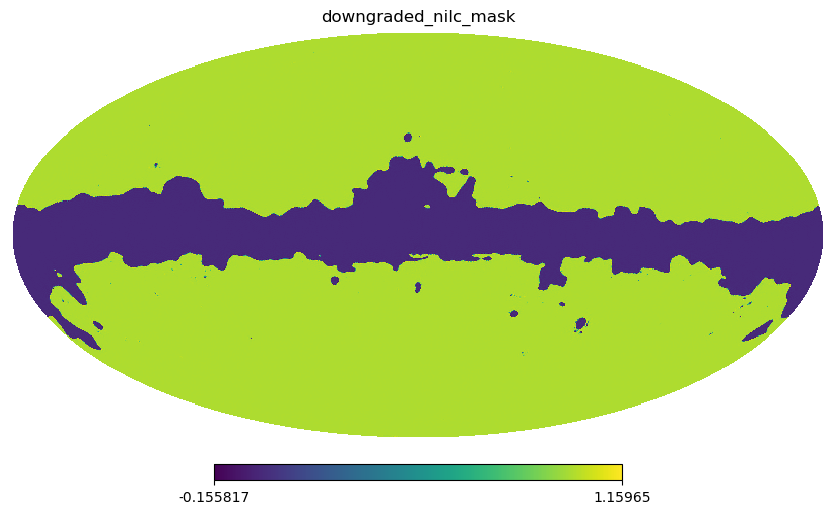

In [74]:
downgraded_nilc_mask = alm_udgrade(nilc_mask, nside)
hp.mollview(downgraded_nilc_mask, title='downgraded_nilc_mask', unit='')

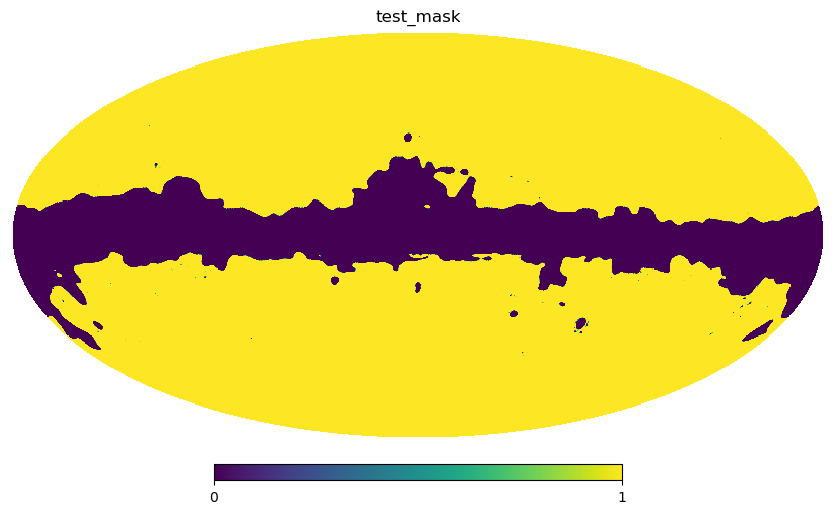

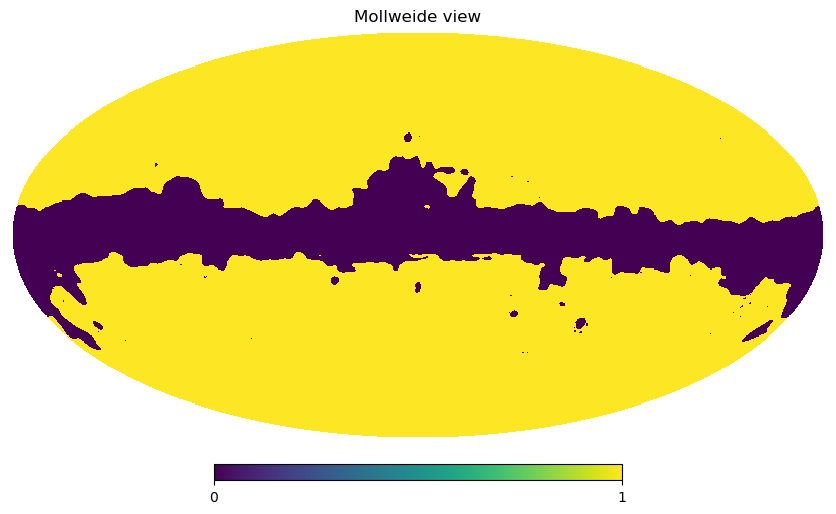

In [75]:
test_mask = hp.ud_grade(nilc_mask, nside_out=nside)
hp.mollview(test_mask, title='test_mask', unit='')
hp.mollview(nilc_mask)

Apply a threshold of 0.5 to mask downgrading

In [76]:
test_mask = (test_mask > 0.5).astype(int)

calculate raw ps

In [77]:
raw_nilc_dl = cal_raw_dl(low_res_nilc_map, 3*nside-1)
ells = np.arange(len(raw_nilc_dl))

calculate masked and apodized masked power spectrum

In [78]:
masked_nilc_dl = cal_masked_dl(low_res_nilc_map, test_mask, 3*nside-1)
apodized_nilc_dl = cal_apod_masked_dl(low_res_nilc_map, test_mask, 3*nside-1, 2)

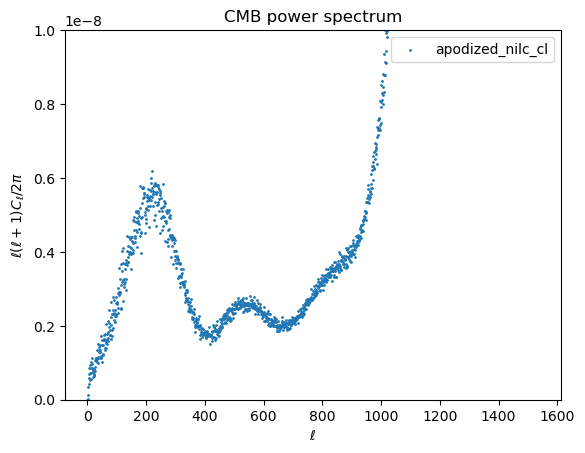

In [79]:
plt.figure()
#plt.scatter(ells, raw_nilc_dl/beam**2, s = 1,label='nilc_cl')
#plt.scatter(ells, masked_nilc_dl/beam**2, s = 1,label='masked_nilc_cl')
plt.scatter(ells, apodized_nilc_dl/beam**2, s = 1,label='apodized_nilc_cl')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.ylim(0, 1e-8)
plt.title('CMB power spectrum')
plt.legend()
plt.show()

Smooth the maps first and then apply the mask

In [80]:
filtered_low_res_nilc_map = beam_deconvol(low_res_nilc_map, beam, nside)

In [81]:
raw_filtered_nilc_dl = cal_raw_dl(filtered_low_res_nilc_map, 3*nside-1)
masked_filtered_nilc_dl = cal_masked_dl(filtered_low_res_nilc_map, test_mask, 3*nside-1)
apodized_masked_filtered_nilc_dl = cal_apod_masked_dl(filtered_low_res_nilc_map, test_mask, 3*nside-1, 2)

In [82]:
ell, planck_dl, delta_minus_dl, delta_plus_dl = np.genfromtxt('/home/yunan/COM_PowerSpect_CMB-TT-full_R3.01.txt', unpack=True)

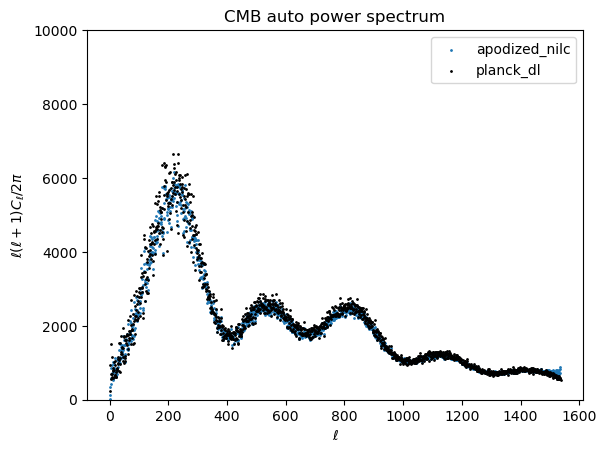

In [110]:
k2muk = 1e12
ells = np.arange(len(apodized_masked_filtered_nilc_dl))

plt.figure()
#plt.scatter(ells, raw_filtered_nilc_dl*k2muk, s = 1,label='filtered_nilc_cl')
#plt.scatter(ells, masked_filtered_nilc_dl*k2muk, s = 1,label='masked_filtered_nilc_cl')
plt.scatter(ells, apodized_masked_filtered_nilc_dl*k2muk, s = 1,label='apodized_nilc')
plt.scatter(ell[:3*nside - 1], planck_dl [: 3*nside - 1], s = 1, label='planck_dl', color='black')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.ylim(0, 1e4)
plt.title('CMB auto power spectrum')
plt.legend()
plt.show()

Absolute difference and relative difference before debias

In [84]:
abs_error_raw = absolute_error(raw_filtered_nilc_dl*k2muk, planck_dl [: 3*nside ])
abs_error_masked = absolute_error(masked_filtered_nilc_dl*k2muk, planck_dl [: 3*nside ])
abs_error_apodized = absolute_error(apodized_masked_filtered_nilc_dl*k2muk, planck_dl [: 3*nside ])

In [85]:
relative_error_raw = relative_error(raw_filtered_nilc_dl*k2muk, planck_dl [: 3*nside ])
relative_error_masked = relative_error(masked_filtered_nilc_dl*k2muk, planck_dl [: 3*nside ])
relative_error_apodized = relative_error(apodized_masked_filtered_nilc_dl*k2muk, planck_dl [: 3*nside ])

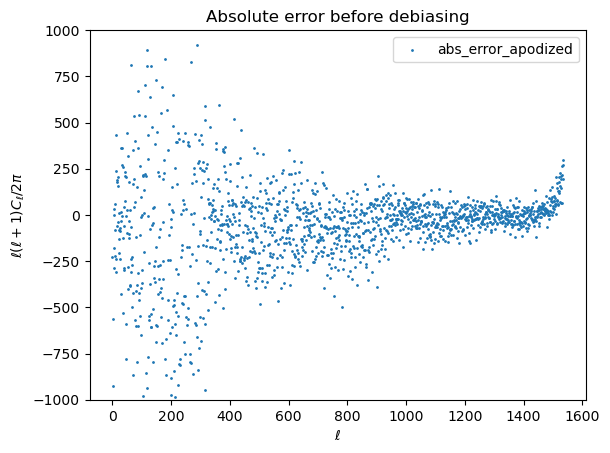

In [112]:
plt.figure()
#plt.scatter(ells, abs_error_raw, s = 1,label='abs_error_raw')
#plt.scatter(ells, abs_error_masked, s = 1,label='abs_error_masked')
plt.scatter(ells, abs_error_apodized, s = 1,label='abs_error_apodized')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.ylim(-1e3, 1e3)
plt.title('Absolute error before debiasing')
plt.legend()
plt.show()


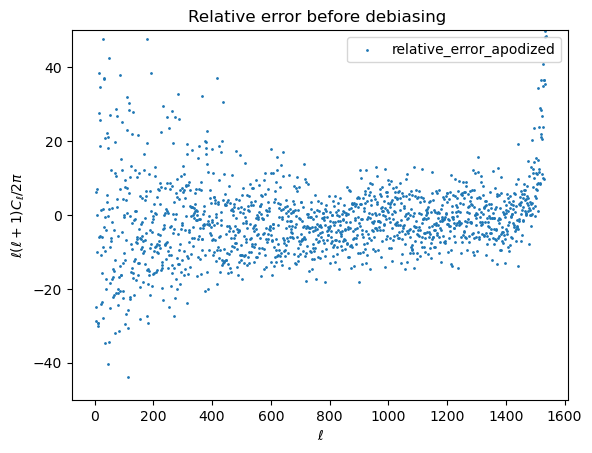

In [111]:
plt.figure()
#plt.scatter(ells, relative_error_raw, s = 1,label='relative_error_raw')
#plt.scatter(ells, relative_error_masked, s = 1,label='relative_error_masked')
plt.scatter(ells, relative_error_apodized, s = 1,label='relative_error_apodized')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.ylim(-50, 50)
plt.title('Relative error before debiasing ')
plt.legend()


Load half mission maps at 2048

In [88]:
nilc_hm1_path = '/home/yunan/planck_release/half_mission/COM_CMB_IQU-nilc_2048_R3.00_hm1.fits'
nilc_hm2_path = '/home/yunan/planck_release/half_mission/COM_CMB_IQU-nilc_2048_R3.00_hm2.fits'
nilc_hm1_map = hp.read_map(nilc_hm1_path, field=(0, 1, 2))
nilc_hm2_map = hp.read_map(nilc_hm2_path, field=(0, 1, 2))

Smooth the maps and downgrade

In [89]:
filtered_nilc_hm1_map = beam_deconvol(nilc_hm1_map[0], nilc_beam, 2048)
filtered_nilc_hm2_map = beam_deconvol(nilc_hm2_map[0], nilc_beam, 2048)

downgraded_nilc_hm1_map = alm_udgrade(filtered_nilc_hm1_map, nside)
downgraded_nilc_hm2_map = alm_udgrade(filtered_nilc_hm2_map, nside)

low_res_nilc_hm1_map = beam_deconvol(downgraded_nilc_hm1_map, 1/beam, nside)
low_res_nilc_hm2_map = beam_deconvol(downgraded_nilc_hm2_map, 1/beam, nside)

Beam deconvolution

In [90]:
filtered_low_res_nilc_hm1_map = beam_deconvol(low_res_nilc_hm1_map, beam, nside)
filtered_low_res_nilc_hm2_map = beam_deconvol(low_res_nilc_hm2_map, beam, nside)

Calculate raw cl and dl

In [91]:
raw_filtered_low_res_nilc_hm12_dl = cal_raw_dl(filtered_low_res_nilc_hm1_map, 3*nside-1, filtered_low_res_nilc_hm2_map)

Calculate masked cl and dl

In [92]:
masked_filtered_low_res_nilc_hm12_dl = cal_masked_dl(filtered_low_res_nilc_hm1_map, test_mask, 3*nside-1, filtered_low_res_nilc_hm2_map)

Calculate masked cl and dl with apodized mask

In [93]:
apodized_filtered_low_res_nilc_hm12_dl = cal_apod_masked_dl(filtered_low_res_nilc_hm1_map, test_mask, 3*nside-1, 2, filtered_low_res_nilc_hm2_map)

Plot cross-ps

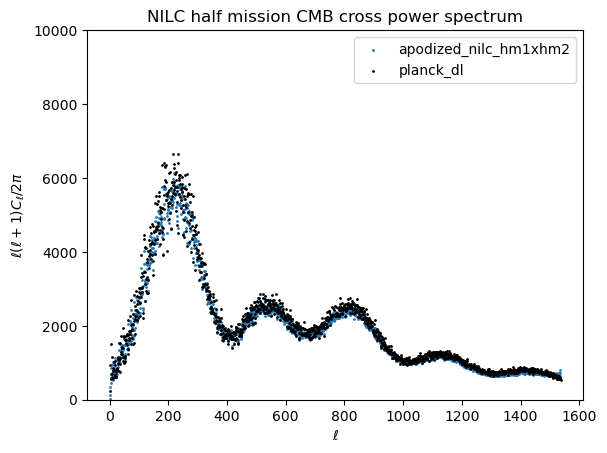

In [113]:
plt.figure()
#plt.scatter(ells, raw_filtered_low_res_nilc_hm12_dl*k2muk, s = 1,label='filtered_low_res_nilc_hm12_dl')
#plt.scatter(ells, masked_filtered_low_res_nilc_hm12_dl*k2muk, s = 1,label='masked_filtered_low_res_nilc_hm12_dl')
plt.scatter(ells, apodized_filtered_low_res_nilc_hm12_dl*k2muk, s = 1,label='apodized_nilc_hm1xhm2')
plt.scatter(ell[:3*nside - 1], planck_dl [: 3*nside - 1], s = 1, label='planck_dl', color='black')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.ylim(0, 1e4)
plt.title('NILC half mission CMB cross power spectrum')
plt.legend()
plt.show()

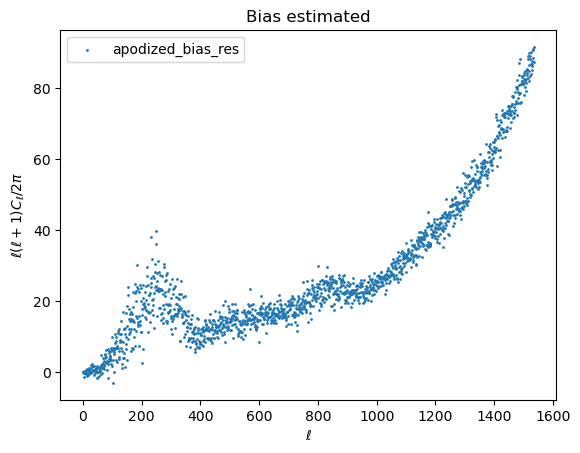

In [114]:
raw_bias_res = raw_filtered_nilc_dl - raw_filtered_low_res_nilc_hm12_dl
masked_bias_res = masked_filtered_nilc_dl - masked_filtered_low_res_nilc_hm12_dl
apodized_bias_res = apodized_masked_filtered_nilc_dl - apodized_filtered_low_res_nilc_hm12_dl
plt.figure()
#plt.scatter(ells, raw_bias_res*k2muk, s = 1,label='raw_bias_res')
#plt.scatter(ells, masked_bias_res*k2muk, s = 1,label='masked_bias_res')
plt.scatter(ells, apodized_bias_res*k2muk, s = 1,label='apodized_bias_res')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
#plt.ylim(-1e3, 1e3)
plt.title('Bias estimated')
plt.legend()
plt.show()

Remove the bias from prediction

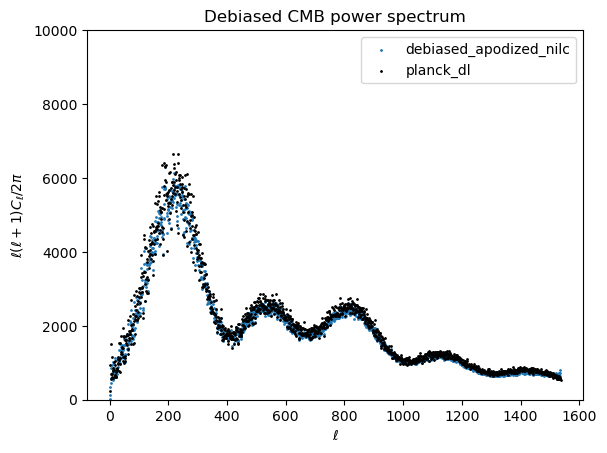

In [115]:
debiased_raw_filtered_nilc_dl = raw_filtered_nilc_dl - raw_bias_res
debiased_masked_filtered_nilc_dl = masked_filtered_nilc_dl - masked_bias_res
debiased_apodized_filtered_nilc_dl = apodized_masked_filtered_nilc_dl - apodized_bias_res
plt.figure()
#plt.scatter(ells, debiased_raw_filtered_nilc_dl*k2muk, s = 1,label='debiased_raw_filtered_nilc_dl')
#plt.scatter(ells, debiased_masked_filtered_nilc_dl*k2muk, s = 1,label='debiased_masked_filtered_nilc_dl')
plt.scatter(ells, debiased_apodized_filtered_nilc_dl*k2muk, s = 1,label='debiased_apodized_nilc')
plt.scatter(ell[:3*nside - 1], planck_dl [: 3*nside - 1], s = 1, label='planck_dl', color='black')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.ylim(0, 1e4)
plt.title('Debiased CMB power spectrum')
plt.legend()
plt.show()

Absolute difference and relative differene after debias

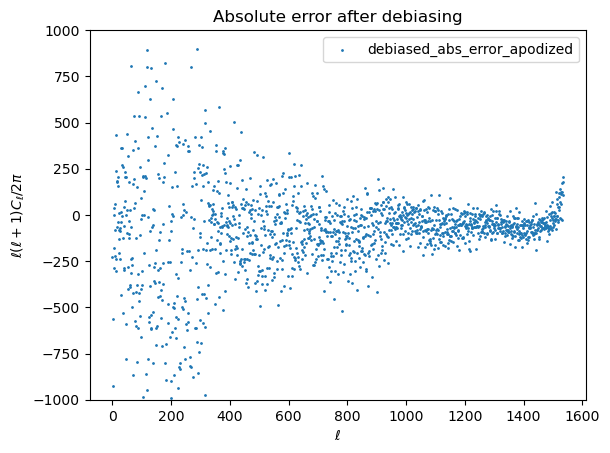

In [ ]:
debiased_abs_error_raw = absolute_error(debiased_raw_filtered_nilc_dl*k2muk, planck_dl [: 3*nside ])
debiased_abs_error_masked = absolute_error(debiased_masked_filtered_nilc_dl*k2muk, planck_dl [: 3*nside ])
debiased_abs_error_apodized = absolute_error(debiased_apodized_filtered_nilc_dl*k2muk, planck_dl [: 3*nside ])

plt.figure()
#plt.scatter(ells, debiased_abs_error_raw, s = 1,label='debiased_abs_error_raw')
#plt.scatter(ells, debiased_abs_error_masked, s = 1,label='debiased_abs_error_masked')
plt.scatter(ells, debiased_abs_error_apodized, s = 1,label='debiased_abs_error_apodized')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.ylim(-1e3, 1e3)
plt.title('Absolute error after debiasing')
plt.legend()
plt.show()


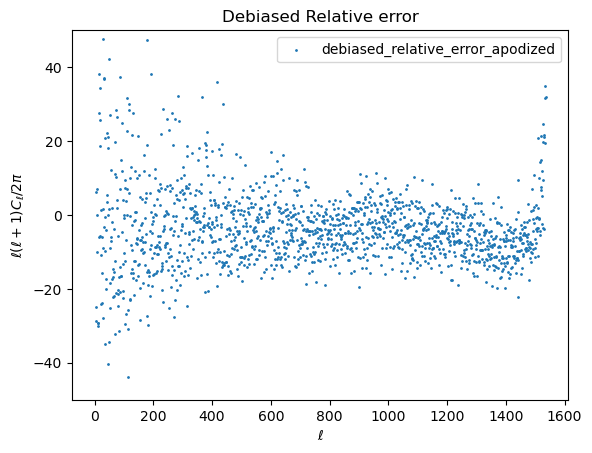

In [98]:
debiased_relative_error_raw = relative_error(debiased_raw_filtered_nilc_dl*k2muk, planck_dl [: 3*nside ])
debiased_relative_error_masked = relative_error(debiased_masked_filtered_nilc_dl*k2muk, planck_dl [: 3*nside ])
debiased_relative_error_apodized = relative_error(debiased_apodized_filtered_nilc_dl*k2muk, planck_dl [: 3*nside ])

plt.figure()
#plt.scatter(ells, debiased_relative_error_raw, s = 1,label='debiased_relative_error_raw')
#plt.scatter(ells, debiased_relative_error_masked, s = 1,label='debiased_relative_error_masked')
plt.scatter(ells, debiased_relative_error_apodized, s = 1,label='debiased_relative_error_apodized')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.ylim(-50, 50)
plt.title('Debiased Relative error')
plt.legend()
plt.show()

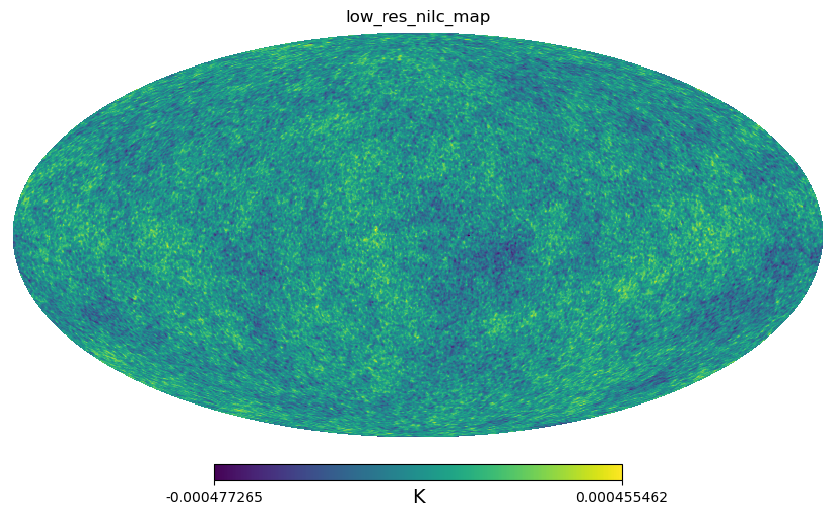

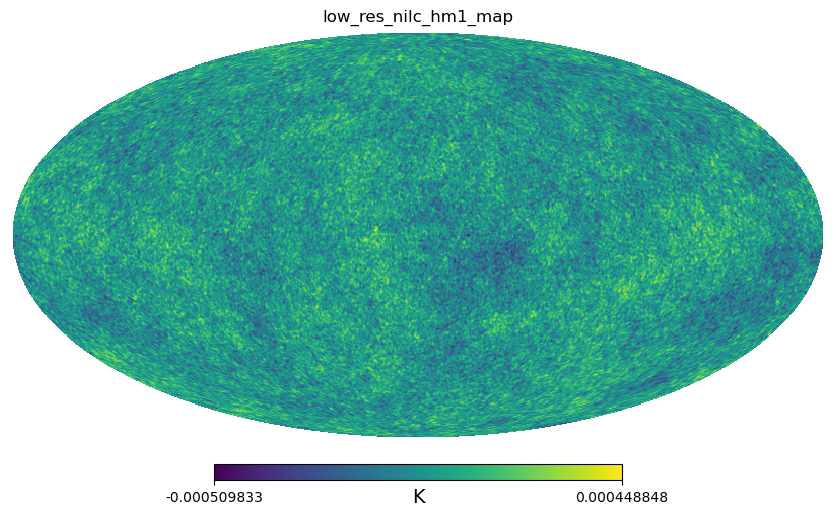

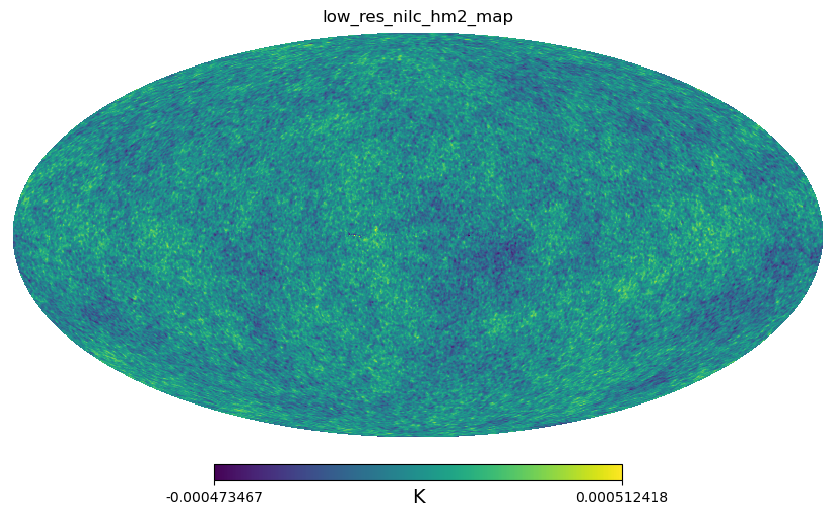

In [99]:
hp.mollview(low_res_nilc_map, title='low_res_nilc_map', unit='K')
hp.mollview(low_res_nilc_hm1_map, title='low_res_nilc_hm1_map', unit='K')
hp.mollview(low_res_nilc_hm2_map, title='low_res_nilc_hm2_map', unit='K')


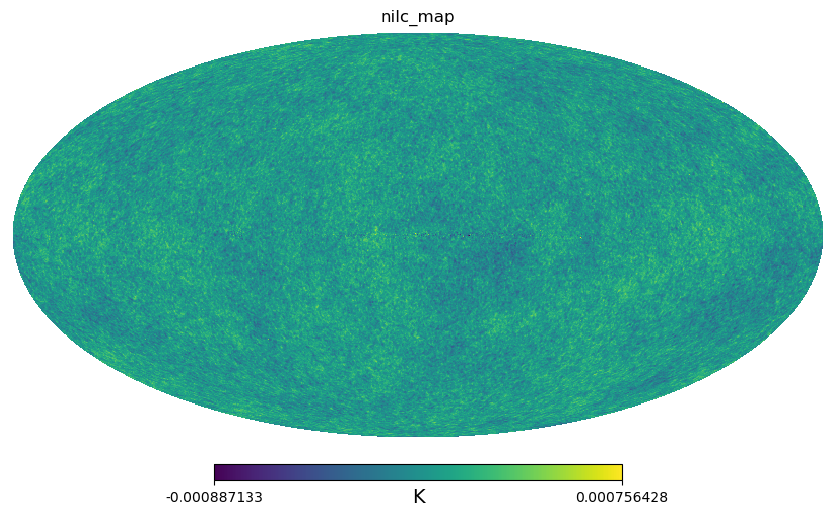

In [100]:
hp.mollview(nilc_imp_map, title='nilc_map', unit='K')

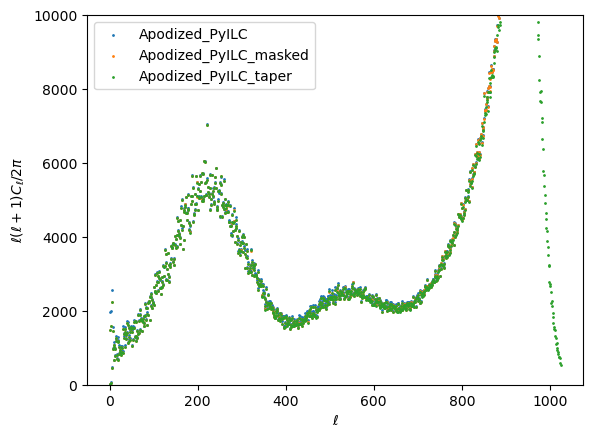

In [117]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import astropy.io.fits as fits

# Functions
def get_alms(map_in):
    nside_in = hp.get_nside(map_in)
    lmax_in = 2*nside_in
    alm = hp.map2alm(map_in, lmax = lmax_in)
    return alm
def beam_deconvol(map_in, beam, nside):
    alm_in = get_alms(map_in)
    alm_out = hp.almxfl(alm_in, 1/beam)
    map_out = hp.alm2map(alm_out, nside)
    return map_out

def apply_mask(map, mask):
    masked_index = np.where(mask != 1)
    masked_map = map.copy()
    masked_map[masked_index] = hp.UNSEEN
    masked_map = hp.ma(masked_map)
    #masked_map.mask = mask
    return masked_map
def calc_fsky(mask):
    return np.sum(mask**2)/len(mask)

def cal_apod_masked_dl(map_in1, mask_in, ellmax, apod_scale, map_in2 = None):
    apodized_mask = nmt.mask_apodization(mask_in, apod_scale, apotype='C2')
    fsky = calc_fsky(apodized_mask)
    if map_in2 is not None:
        masked_map1 = apply_mask(map_in1, apodized_mask)
        masked_map2 = apply_mask(map_in2, apodized_mask)
        masked_cl = hp.anafast(masked_map1, masked_map2, lmax=ellmax)
    else:
        masked_map = apply_mask(map_in1, apodized_mask)
        masked_cl = hp.anafast(masked_map, lmax=ellmax)
    ell_temp = np.arange(len(masked_cl))
    masked_dl = ell_temp * (ell_temp + 1) * masked_cl / (2 * np.pi) / fsky
    return masked_dl

# Global variables
nside = 512
lmax = 2*nside
apodization_scale = 2

# Mask and beam
beam_fwhm = 20.6
beam_fwhm = beam_fwhm*np.pi / 60 / 180 
beam = hp.gauss_beam(beam_fwhm, lmax= lmax)
mask_path = '/shared/data/Datasets/I_512_1450_variance_noise/Simulation_Mask/mask.fits'
mask = hp.read_map(mask_path)


# Load the output map and deconvolve the beam
pyilc_map_path = '/home/yunan/pyilc/output/cnilc_pred/valid_sim0000/CN_needletILCmap_component_CMB.fits'
masked_pyilc_path = '/home/yunan/pyilc/output/cnilc_pred/valid_sim0000_masked/CN_needletILCmap_component_CMB.fits'
test_taper_path = '/home/yunan/pyilc/output/cnilc_pred/valid_sim0000_taper_50/CN_needletILCmap_component_CMB.fits'
pyilc_map = hp.read_map(pyilc_map_path)
masked_pyilc_map = hp.read_map(masked_pyilc_path)
test_taper_map = hp.read_map(test_taper_path)
deconvolved_pyilc_map = beam_deconvol(pyilc_map, beam, nside)
deconvolved_masked_pyilc_map = beam_deconvol(masked_pyilc_map, beam, nside)
deconvolved_test_taper_map = beam_deconvol(test_taper_map, beam, nside)

# Calculate the apodized masked dl
masked_dl = cal_apod_masked_dl(deconvolved_pyilc_map, mask, lmax, apodization_scale)
test_masked_dl = cal_apod_masked_dl(deconvolved_masked_pyilc_map, mask, lmax, apodization_scale)
test_tapered_dl = cal_apod_masked_dl(deconvolved_test_taper_map, mask, lmax, apodization_scale)
raw_masked_dl = cal_apod_masked_dl(pyilc_map, mask, lmax, apodization_scale)
beam_deconvollved_masked_dl = raw_masked_dl/beam**2
ells = np.arange(len(masked_dl))

# Plot the dl
plt.figure()
plt.scatter(ells, masked_dl, s = 1, label='Apodized_PyILC')
plt.scatter(ells, test_masked_dl, s = 1, label='Apodized_PyILC_masked')
plt.scatter(ells, test_tapered_dl, s = 1, label='Apodized_PyILC_taper')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.ylim(0, 1e4)
plt.legend()
plt.show()

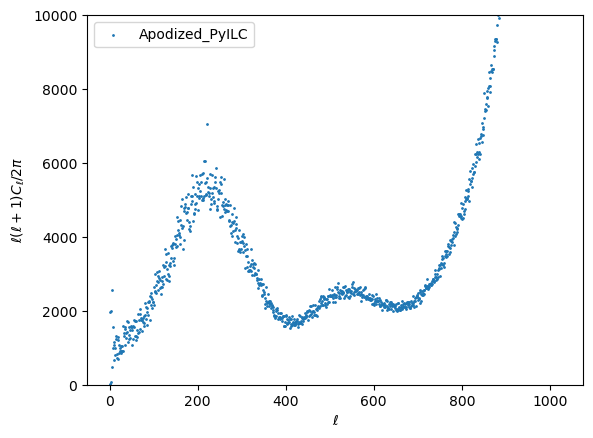

In [102]:
plt.figure()
plt.scatter(ells, masked_dl, s = 1, label='Apodized_PyILC')
#plt.scatter(ells, test_masked_dl, s = 1, label='Apodized_PyILC_masked')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.ylim(0, 1e4)
plt.legend()
plt.show()

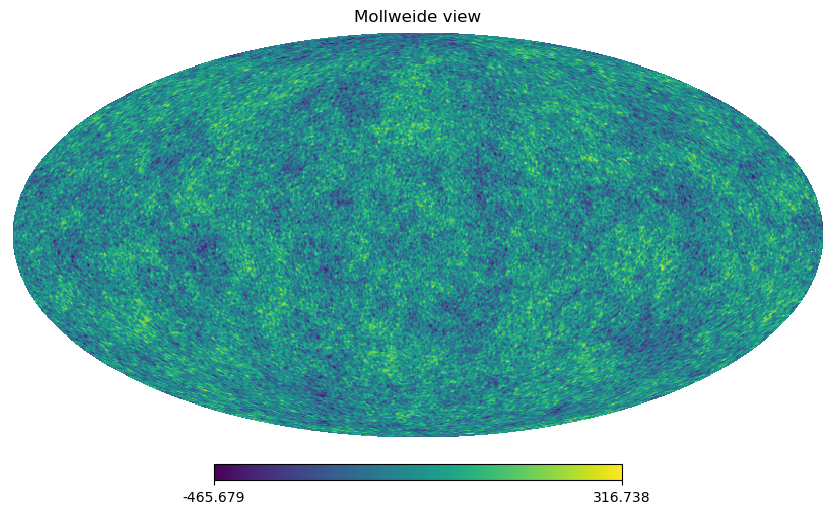

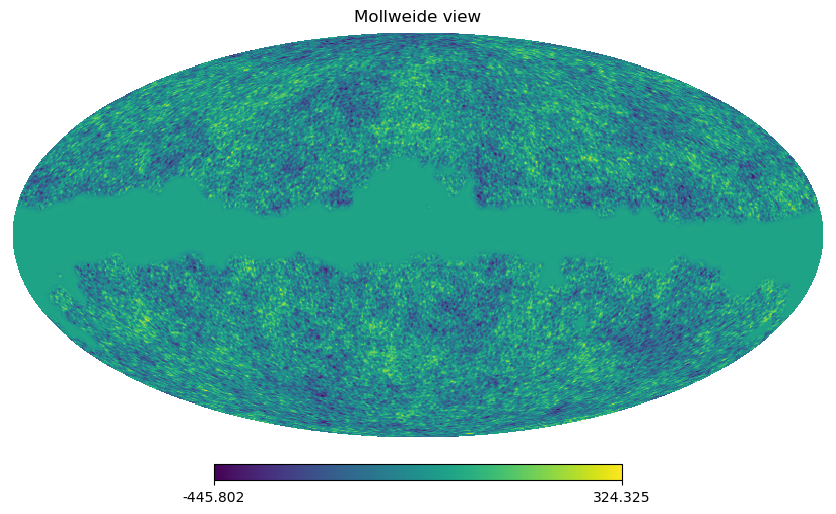

In [103]:
hp.mollview(pyilc_map)
hp.mollview(masked_pyilc_map)